<a href="https://colab.research.google.com/github/IngeborgOlssoen/Chagas-challenge-Hear-heart/blob/main/Chagas_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Content

1. Resumen
2. Setup
3. Helper functions
4. Dataplitting & Balancing of samples
5. Ensemble model (HearHeart)
6. S4 Model
7. Comparison between Ensemble Model and S4 model



#Resumen
En este proyecto, partimos del repositorio oficial de ejemplo en Python proporcionado para el George B. Moody PhysioNet Challenge 2025 (GitHub) para desarrollar y evaluar dos modelos distintos de aprendizaje automático con el objetivo de detectar la enfermedad de Chagas a partir de señales de ECG.

El primer enfoque es un modelo de ensamble, inspirado en la solución ganadora del Heart Murmur Detection Challenge 2022 (HearHeart). Este ensamble combina tres arquitecturas neuronales independientes: un clasificador basado en una red neuronal artificial (ANN), una red convolucional recurrente (CRNN) y un modelo basado en ResNet. Cada modelo se entrena de forma individual, y las predicciones finales se obtienen mediante un promedio ponderado de las probabilidades de salida de cada uno. Esta estrategia aprovecha las diferentes representaciones de características que aprende cada arquitectura para mejorar la robustez y el rendimiento del modelo.

El segundo modelo desarrollado se basa en la arquitectura S4 (Structured State Space Sequence), diseñada para modelar secuencias largas de forma eficiente. Esta arquitectura es especialmente adecuada para procesar señales de ECG multicanal y de larga duración, y ha sido ajustada para predecir directamente la probabilidad de Chagas en cada caso.

Ambos modelos fueron integrados dentro del entorno de evaluación oficial del Challenge, utilizando la función de puntuación proporcionada (compute_challenge_score) y evaluados con la misma metodología para permitir una comparación justa. Todo el flujo de trabajo —incluyendo carga de datos, preprocesamiento de señales, inferencia del modelo, formato de salida y evaluación de resultados— se documenta detalladamente en el notebook disponible en este enlace.

El modelo de ensamble mostró un rendimiento sólido gracias a la complementariedad de sus arquitecturas, mientras que el modelo S4 evidenció potencial para futuras mejoras mediante un ajuste más fino y técnicas de representación especializadas para señales fisiológicas.


# Repo setup

To be able to run the code:

1. Clone a GitHub repository

2. Add the repo to the Python path so their modules can be used directly

3. Install requirements and import neccesary libraries


### Clone repository and locate it

In [ ]:
!git clone -b Slimmed-models https://github.com/IngeborgOlssoen/Chagas-challenge-Hear-heart.git
!cd Chagas-challenge-Hear-heart && ls

Cloning into 'Chagas-challenge-Hear-heart'...
remote: Enumerating objects: 371, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 371 (delta 14), reused 41 (delta 4), pack-reused 313 (from 4)
Receiving objects: 100% (371/371), 169.40 MiB | 49.48 MiB/s, done.
Resolving deltas: 100% (26/26), done.
base_model.py		LICENSE			  requirements.txt
Chagas_challenge.ipynb	model			  run_model.py
dataset			model2			  scores.csv
detailed_scores.csv	prepare_code15_data.py	  script.py
Dockerfile		prepare_ptbxl_data.py	  splitting_data.py
evaluate_model.py	prepare_samitrop_data.py  team_code.py
helper_code.py		__pycache__		  train_model.py
holdout_ouputs		README.md		  train_tmp.csv


In [ ]:
# Clone model repo (Repo 2)
!git clone https://github.com/IngeborgOlssoen/ECG-chagas.git

Cloning into 'ECG-chagas'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 60 (delta 4), reused 55 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (60/60), 1.71 MiB | 17.66 MiB/s, done.
Resolving deltas: 100% (4/4), done.


### Add them as system path

In [ ]:
import sys
sys.path.append('/content/Chagas-challenge-Hear-heart')
sys.path.append('/content/ECG-chagas')

### Requirements and imports

In [ ]:
!pip install wfdb
!pip install -r requirements.txt
!pip install wfdb scikit-learn numpy pandas torch torchvision


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
# Standard libraries
import os
import shutil
import zipfile

# Data handling
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler

# Plotting
import matplotlib.pyplot as plt

# PyTorch
from torch.utils.data import DataLoader, WeightedRandomSampler

# PhysioNet data
import wfdb

# Local challenge modules
from helper_code import (
    load_header,
    load_text,
    get_label,
    get_probability,
    get_source,
    get_age,
    get_sex,
    compute_challenge_score,
    compute_auc,
    compute_accuracy,
    compute_f_measure,
)

from team_code import ECGFromCSV


# Helper function

### Loads predictions and labels for evaluating model

In [ ]:
def load_predictions_and_labels(output_dir):
    labels = []
    probs = []

    for fname in sorted(os.listdir(output_dir)):
        if not fname.endswith('.txt'):
            continue

        path = os.path.join(output_dir, fname)
        content = load_text(path)

        try:
            label = get_label(content)
            prob = get_probability(content)
        except:
            continue  # Skip malformed files

        labels.append(label)
        probs.append(prob)

    return np.array(labels), np.array(probs)

# Ensemble model (HearHeart)

### Run

In [ ]:
!python Chagas-challenge-Hear-heart/run_model.py -d Chagas-challenge-Hear-heart/dataset -m Chagas-challenge-Hear-heart/model -o holdout_outputs_ens -v

Loading the Challenge model...
final model path Chagas-challenge-Hear-heart/model/final_model.pt
model path: Chagas-challenge-Hear-heart/model/audio_classifier_model.pt
model path: Chagas-challenge-Hear-heart/model/crnn_model.pt
model path: Chagas-challenge-Hear-heart/model/resnet_model.pt
folder: Chagas-challenge-Hear-heart/dataset
Finding the Challenge data...
Running the Challenge model on the Challenge data...
-  1/10: 00005_hr...
audio_classifier: pred=1, prob=0.6942, weight=0.45
           crnn: pred=1, prob=0.9669, weight=0.10
         resnet: pred=0, prob=0.0104, weight=0.45

Final avg prob: 0.4710 → Prediction: 0
-  2/10: 00042_hr...
audio_classifier: pred=1, prob=0.6483, weight=0.45
           crnn: pred=1, prob=0.9670, weight=0.10
         resnet: pred=1, prob=0.8567, weight=0.45

Final avg prob: 0.6011 → Prediction: 0
-  3/10: 00044_hr...
audio_classifier: pred=1, prob=0.6182, weight=0.45
           crnn: pred=1, prob=0.9667, weight=0.10
         resnet: pred=0, prob=0.4383

### Evaluate

In [ ]:
!python Chagas-challenge-Hear-heart/evaluate_model.py -d Chagas-challenge-Hear-heart/dataset -o holdout_outputs_ens -s scores.csv

### Metrics & Analysis

In [ ]:
# === Step 1: Load labels and predictions
labels, outputs = load_predictions_and_labels("holdout_outputs_ens")

# === Step 2: Calculate metrics using helper_code
challenge_score = compute_challenge_score(labels, outputs)
auroc, auprc = compute_auc(labels, outputs)
predicted_labels = (outputs >= 0.5).astype(int)
accuracy = compute_accuracy(labels, predicted_labels)
f1 = compute_f_measure(labels, predicted_labels)

# === Step 3: Format nicely with pandas
df = pd.DataFrame({
    "Metric": ["Challenge score", "AUROC", "AUPRC", "Accuracy", "F-measure"],
    "Score": [challenge_score, auroc, auprc, accuracy, f1]
})

# === Step 4: Display
df.style.set_properties(**{"text-align": "center"}).set_table_styles([{
    "selector": "th",
    "props": [("text-align", "center")]
}])


,Metric,Score
0,Challenge score,0.000000
1,AUROC,1.000000
2,AUPRC,1.000000
3,Accuracy,0.600000
4,F-measure,0.523810


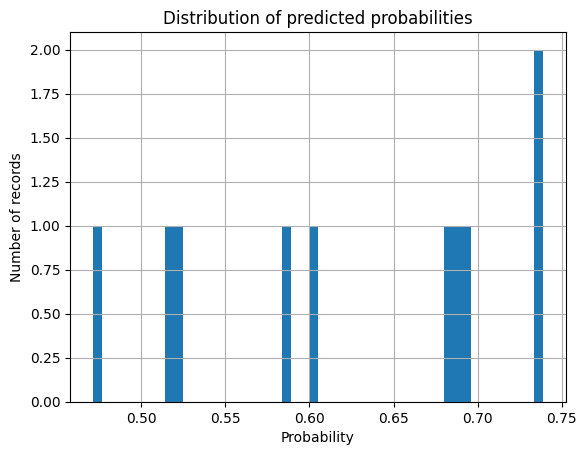

In [ ]:
plt.hist(outputs, bins=50)
plt.title("Distribution of predicted probabilities")
plt.xlabel("Probability")
plt.ylabel("Number of records")
plt.grid(True)
plt.show()


In [ ]:
# Capacity is 5% of total records
capacity = int(0.05 * len(labels))
top_k_indices = np.argsort(outputs)[::-1][:capacity]

# Debug: Show top-k records and if they are positive
for idx in top_k_indices:
    print(f"Index {idx}: prob={outputs[idx]:.4f}, label={labels[idx]}")


In [ ]:
# Indices of all true positive samples
tp_indices = np.where(labels == 1)[0]

# Find which of them are NOT in top_k
missed_tp = [idx for idx in tp_indices if idx not in top_k_indices]

print(f"Missed true positives (not in top 5%): {len(missed_tp)}")
for idx in missed_tp:
    print(f"Index {idx}: prob={outputs[idx]:.4f}")


Missed true positives (not in top 5%): 5
Index 3: prob=0.6924
Index 6: prob=0.6863
Index 7: prob=0.7392
Index 8: prob=0.6810
Index 9: prob=0.7383


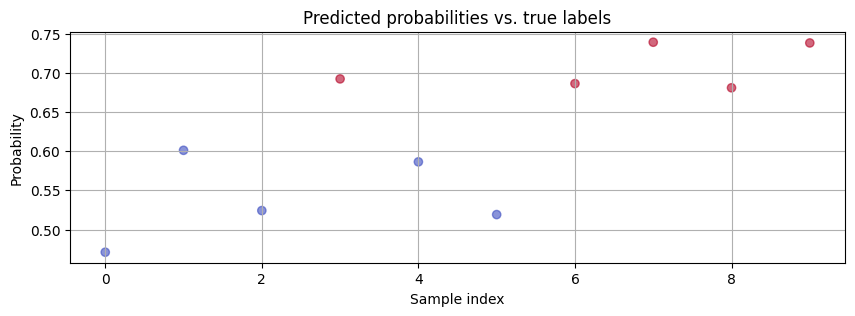

In [ ]:
plt.figure(figsize=(10, 3))
plt.scatter(range(len(outputs)), outputs, c=labels, cmap='coolwarm', alpha=0.6)
plt.title("Predicted probabilities vs. true labels")
plt.xlabel("Sample index")
plt.ylabel("Probability")
plt.grid(True)
plt.show()


# S4 Model

### Run

In [ ]:
!python Chagas-challenge-Hear-heart/run_model.py -d Chagas-challenge-Hear-heart/dataset -m Chagas-challenge-Hear-heart/model2 -o holdout_outputs_s4 -v

Loading the Challenge model...
final model path Chagas-challenge-Hear-heart/model2/final_model.pt
folder: Chagas-challenge-Hear-heart/dataset
Finding the Challenge data...
Running the Challenge model on the Challenge data...
-  1/10: 00005_hr...
Traceback (most recent call last):
  File "/content/Chagas-challenge-Hear-heart/run_model.py", line 90, in <module>
    run(get_parser().parse_args(sys.argv[1:]))
  File "/content/Chagas-challenge-Hear-heart/run_model.py", line 67, in run
    binary_output, probability_output = run_model(os.path.join(args.data_folder, record), model, args.verbose) ### Teams: Implement this function!!!
                                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/Chagas-challenge-Hear-heart/team_code.py", line 137, in run_model
    prob = models(signal_tensor).item()
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: a Tensor with 8 elements cannot be converted to Scalar


### Evaluate

In [ ]:
!python Chagas-challenge-Hear-heart/evaluate_model.py -d Chagas-challenge-Hear-heart/dataset -o holdout_outputs_s4 -s scores.csv

Traceback (most recent call last):
  File "/content/Chagas-challenge-Hear-heart/evaluate_model.py", line 130, in <module>
    run(get_parser().parse_args(sys.argv[1:]))
  File "/content/Chagas-challenge-Hear-heart/evaluate_model.py", line 114, in run
    challenge_score, auroc, auprc, accuracy, f_measure = evaluate_model(args.data_folder, args.output_folder)
                                                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/Chagas-challenge-Hear-heart/evaluate_model.py", line 66, in evaluate_model
    raise FileNotFoundError('No binary outputs found.')
FileNotFoundError: No binary outputs found.


### Metrics & Analysis

In [ ]:


# === Step 1: Load labels and predictions
labels, outputs = load_predictions_and_labels("holdout_outputs_s4")

# === Step 2: Calculate metrics using helper_code
challenge_score = compute_challenge_score(labels, outputs)
auroc, auprc = compute_auc(labels, outputs)
predicted_labels = (outputs >= 0.5).astype(int)
accuracy = compute_accuracy(labels, predicted_labels)
f1 = compute_f_measure(labels, predicted_labels)

# === Step 3: Format nicely with pandas
df = pd.DataFrame({
    "Metric": ["Challenge score", "AUROC", "AUPRC", "Accuracy", "F-measure"],
    "Score": [challenge_score, auroc, auprc, accuracy, f1]
})

# === Step 4: Display
df.style.set_properties(**{"text-align": "center"}).set_table_styles([{
    "selector": "th",
    "props": [("text-align", "center")]
}])


FileNotFoundError: [Errno 2] No such file or directory: 'holdout_outputs_s4'

In [ ]:
import matplotlib.pyplot as plt

plt.hist(outputs, bins=50)
plt.title("Distribution of predicted probabilities")
plt.xlabel("Probability")
plt.ylabel("Number of records")
plt.grid(True)
plt.show()


In [ ]:
# Capacity is 5% of total records
capacity = int(0.05 * len(labels))
top_k_indices = np.argsort(outputs)[::-1][:capacity]

# Debug: Show top-k records and if they are positive
for idx in top_k_indices:
    print(f"Index {idx}: prob={outputs[idx]:.4f}, label={labels[idx]}")


In [ ]:
# Indices of all true positive samples
tp_indices = np.where(labels == 1)[0]

# Find which of them are NOT in top_k
missed_tp = [idx for idx in tp_indices if idx not in top_k_indices]

print(f"Missed true positives (not in top 5%): {len(missed_tp)}")
for idx in missed_tp:
    print(f"Index {idx}: prob={outputs[idx]:.4f}")


In [ ]:
plt.figure(figsize=(10, 3))
plt.scatter(range(len(outputs)), outputs, c=labels, cmap='coolwarm', alpha=0.6)
plt.title("Predicted probabilities vs. true labels")
plt.xlabel("Sample index")
plt.ylabel("Probability")
plt.grid(True)
plt.show()


# Comparison between ensemble model and S4 model

In [ ]:
def evaluate_model(pred_path: str):
    # Load labels and predicted probabilities
    labels, outputs = load_predictions_and_labels(pred_path)

    # Compute metrics
    challenge_score = compute_challenge_score(labels, outputs)
    auroc, auprc = compute_auc(labels, outputs)
    predicted_labels = (outputs >= 0.5).astype(int)
    accuracy = compute_accuracy(labels, predicted_labels)
    f1 = compute_f_measure(labels, predicted_labels)

    return {
        "Challenge score": challenge_score,
        "AUROC": auroc,
        "AUPRC": auprc,
        "Accuracy": accuracy,
        "F-measure": f1
    }

# === Evaluate both models
s4_scores = evaluate_model("holdout_outputs_s4")
ens_scores = evaluate_model("holdout_outputs_ens")

# === Combine into a DataFrame
comparison_df = pd.DataFrame({
    "Metric": list(s4_scores.keys()),
    "S4D_final_model.pt": list(s4_scores.values()),
    "Ensemble_model.pt": [ens_scores[m] for m in s4_scores.keys()]
})

# === Display the tidy table
comparison_df.set_index("Metric", inplace=True)
display(comparison_df)

### Metadata Collection Helpers

In [ ]:
def gather_file_metadata(subdir):
    hea_files = sorted([f for f in os.listdir(os.path.join(DATA_DIR, subdir)) if f.endswith(".hea")])
    data = []
    for hea_file in hea_files:
        base = hea_file.replace(".hea", "")
        dat_path = os.path.join(DATA_DIR, subdir, base + ".dat")
        hea_path = os.path.join(DATA_DIR, subdir, hea_file)

        if not os.path.exists(dat_path):
            continue

        header = load_header(hea_path)
        label = get_label(header)
        source = get_source(header)
        age = get_age(header)
        sex = get_sex(header)

        data.append({
            "record_id": base,
            "dat_path": dat_path,
            "hea_path": hea_path,
            "label": label,
            "source": source,
            "age": age,
            "sex": sex,
            "subdir": subdir
        })
    return pd.DataFrame(data)


# Datasplitting & Balancing of samples (dont think we need this)

## Clean directory

In [ ]:
def clean_dir(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
    else:
        for f in os.listdir(folder):
            if f.endswith(".dat") or f.endswith(".hea"):
                os.remove(os.path.join(folder, f))


## Combine + Split + Compute Class Weights

In [ ]:
def combine_and_split_all():
    print("\n Removing files that was already there.")
    clean_dir(os.path.join(DATA_DIR, "train"))
    clean_dir(os.path.join(DATA_DIR, "val"))
    clean_dir(os.path.join(DATA_DIR, "test"))
    print("\n Collecting all .hea/.dat files and labels")

    df_ptbxl = gather_file_metadata("ptbxl_output/ptbxl_output")
    df_samitrop = gather_file_metadata("samitrop_output/samitrop_output")

    df_all = pd.concat([df_ptbxl, df_samitrop], ignore_index=True)
    print(f" Total records found: {len(df_all)}")
    print("Label distribution in full dataset:")
    print(df_all['label'].value_counts())

    df_trainval, df_test = train_test_split(df_all, test_size=0.15, stratify=df_all["label"], random_state=42)
    df_train, df_val = train_test_split(df_trainval, test_size=0.1765, stratify=df_trainval["label"], random_state=42)

    print("\n📊 Train:")
    print(df_train["label"].value_counts())
    print("📊 Val:")
    print(df_val["label"].value_counts())
    print("📊 Test:")
    print(df_test["label"].value_counts())

    y_train = df_train["label"].values
    class_weights = compute_class_weight(class_weight="balanced", classes=np.array([0, 1]), y=y_train)
    weight_dict = {0: class_weights[0], 1: class_weights[1]}

    print("\n✅ Class weights:")
    print(weight_dict)

    return df_train, df_val, df_test, weight_dict


## Save Records to Split Folders

In [ ]:
def save_records(df, out_dir):
    clean_dir(out_dir)
    for _, row in df.iterrows():
        base = row["record_id"]
        subdir = row["subdir"]
        for ext in [".hea", ".dat"]:
            src = os.path.join(DATA_DIR, subdir, base + ext)
            dst = os.path.join(out_dir, base + ext)
            if os.path.exists(src):
                shutil.copy(src, dst)


## Run Full Split + Save Folders

In [ ]:
df_train, df_val, df_test, weight_dict = combine_and_split_all()

save_records(df_train, os.path.join(DATA_DIR, "train"))
save_records(df_val, os.path.join(DATA_DIR, "val"))
save_records(df_test, os.path.join(DATA_DIR, "test"))

## Create Balanced Sampler & Train Loader

In [ ]:


# --- Custom create_balanced_sampler ---
def create_balanced_sampler(dataset):
    labels = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        labels.append(int(label.item()))
    labels = np.array(labels)

    label_counts = np.bincount(labels)
    class_weights = 1.0 / label_counts
    sample_weights = class_weights[labels]
    return WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# --- Usage ---
train_dataset = ECGFromCSV('/content/drive/MyDrive/chagas_datasets/train', augment=True)
sampler = create_balanced_sampler(train_dataset)
train_loader = DataLoader(train_dataset, batch_size=16, sampler=sampler)


In [ ]:
from collections import Counter
samples = [df_train['label'].iloc[i] for i in list(sampler)]
print(Counter(samples))